In [1]:
import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import time
import json
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation
from src.feature_selection import CustomRFECV
from src.feature_selection import IntrinsicFeatureSelection as ifs
from src.plotting import plot_pairwise_correlations

# Load in the data

In [2]:
proc = GatherFeatureDatasets(is_p=True)

In [3]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')

In [4]:
# Use station YUF for experimenting with models because it has 1433 training examples, 
# which is ~half as much as YNR, so training should go faster. But should still be enough 
# examples for training good models. It is also one of the stations with a 
# UUSS correction, so already used for magnitude calculations and amplitudes should be good quality. 
stat = "YUF"
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YUF
X shape: (1433, 45), y shape: (1433,)


In [5]:
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

# RFE to select N

Updates I need to make:

- RFECV is the outer loop
- Select N based on predictor model performance not estimator model performance
- tune predictor model hyperparameter for each N for each fold (optional?)
- Save the optimal N features from each fold 
- For each fold, do RFE with relative and absolute location information
- Save optimal N features (based on average performance for N over all folds) from the entire training set 
- Use MI to limit amplitudes and amplitude ratios (optional?)

In [6]:
### Set Parameters ###
cv_random_state=2652124
# The model to used to estimate feature importance 
estimator_model =  DecisionTreeRegressor()
# Boolean - True if data for estimator_model needs to be scaled
estimator_scaler = False
# The main model to fit
predictor_model = SVR(kernel='rbf')
# Boolean - True if data for model needs to be scaled 
model_scaler = True
# The scoring method to use in RFECV and GridCV
scoring_method = 'r2'
# The function used to evaluate the performance on the test model
score_func = r2_score
# True if a larger score_func value is better
larger_score_is_better = True
# The parameter space for GridCV to search
# Decrease upper-limit of C for linear model because 100 is very slow 
svr_Cspace = [1, 10, 100]
svr_gspace = [0.1, 0.01, 0.001]
param_grid = [
    {'m__C': svr_Cspace, 'm__gamma': svr_gspace},
]
# The number of jobs for RFECV and GridCV to use
n_jobs = 10
# number of folds for outer CV
cv_folds_outer = 10
# number of times to repeat outer CV
n_outer_repeats = 1
# number of folds for inner CV (used for hyperparameter tuning)
cv_folds_inner = 5
# number of folds for the final hyperparameter grid search
cv_folds_hp = 10
# Run grid search over all features
run_gridsearchcv_all = True

### Intrisic feature selection information 
# Function that takes in X, y, list of np arrays containing 
# the indices of features to filter, and K features to select
if_feat_inds = [np.arange(0, 18), np.arange(18, 36)]
if_K = 5
#####################

In [7]:
X = station_feature_dict['X_train']
y = station_meta_dict['y_train']

In [78]:
N_feats_to_use, feat_selection_results = CustomRFECV.do_rfecv(X,
                                                            y,
                                                            estimator_model,
                                                            predictor_model,
                                                            param_grid,
                                                            estimator_scaler=estimator_scaler,
                                                            predictor_scaler=model_scaler,
                                                            score_func=score_func,
                                                            scoring_method=scoring_method,
                                                            n_jobs=n_jobs,
                                                            cv_folds_outer=cv_folds_outer,
                                                            cv_folds_inner=cv_folds_inner,
                                                            n_outer_repeats=n_outer_repeats,
                                                            cv_random_state=cv_random_state,
                                                            larger_score_is_better=larger_score_is_better,
                                                            intrinsic_filter_func=ifs.MI_filter_func,
                                                            feature_inds_to_filter=if_feat_inds,
                                                            intrinsic_filter_K=if_K
                                                            )

reducing features to 19


KeyboardInterrupt: 

In [ ]:
full_score_array = feat_selection_results['RFECV_N_scores']
N_avgs = np.average(full_score_array, axis=0)
N_min = np.min(full_score_array, axis=0)
N_max = np.max(full_score_array, axis=0)

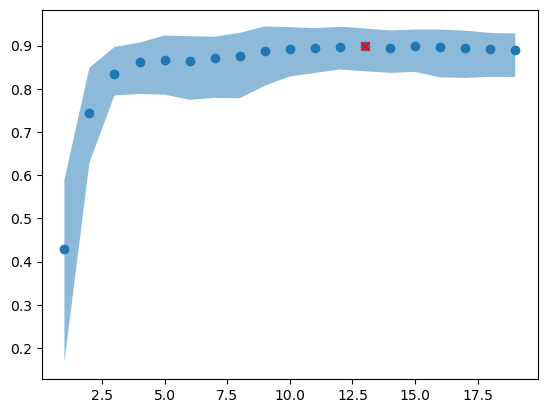

In [ ]:
x = np.arange(N_avgs.shape[0])+1
plt.fill_between(x, N_min, N_max, alpha=0.5)
plt.scatter(x, N_avgs, color='C0')
plt.scatter(N_feats_to_use, N_avgs[N_feats_to_use-1], marker="x", color='r')


# Get N features from entire training set (with same MI filtering and RFE with N features)

In [ ]:
# Filter the entire training dataset using MI and the same parameters used in CV
mi_selected_features, mi_filtered_feature_inds = ifs.MI_filter_func(X, 
                                                                        y, 
                                                                        if_feat_inds, 
                                                                        if_K)

In [ ]:
print(feature_names[mi_selected_features[0]], feature_names[mi_selected_features[1]])

['amp_ratio_11' 'amp_ratio_7' 'amp_ratio_1' 'amp_ratio_3' 'amp_ratio_5'] ['amp_1' 'amp_2' 'amp_3' 'amp_4' 'amp_7']


In [ ]:
X_mi = X[:, mi_filtered_feature_inds]
print(X_mi.shape)

(1433, 19)


In [9]:
estimator_pipeline = CrossValidation.make_simple_pipeline(estimator_model, 
                                                          estimator_scaler)
hp_grid_search, hp_cv = CrossValidation.setup_cv(predictor_model, 
                                                param_grid, 
                                                model_scaler=model_scaler, 
                                                scoring_method=scoring_method, 
                                                n_jobs=n_jobs, 
                                                cv_folds=cv_folds_outer, 
                                                cv_random_state=cv_random_state, 
                                                refit_model=False)

In [ ]:
fselector, gs_results, _ = CustomRFECV.custom_rfe(X_mi, 
                                                    y,
                                                    estimator_pipeline,
                                                    N_feats_to_use,
                                                    hp_grid_search)

In [ ]:
feature_names[mi_filtered_feature_inds[fselector.support_]]

array(['amp_ratio_3', 'amp_ratio_5', 'amp_ratio_7', 'amp_1', 'amp_2',
       'amp_3', 'amp_4', 'amp_7', 'signal_dominant_amplitude',
       'signal_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [ ]:
CrossValidation.get_gridsearchcv_best_results(gs_results)

(0.9017853199556468, 0.033898228664387, {'m__C': 100, 'm__gamma': 0.01})

# Reduce correlated features

In [8]:
# Get correlation values below the diagonal
thresh = 0.75
feature_corr_tril = np.tril(pd.DataFrame(X).corr(), -1)
feature_corr = pd.DataFrame(X).corr()
dropped_feature_inds = []
for i in range(feature_corr.shape[0]):
    max_corr = np.nanmax(feature_corr_tril)
    if max_corr < thresh:
        break
    print(max_corr)
    A, B = np.unravel_index(np.nanargmax(feature_corr_tril), feature_corr.shape)
    A_corrs = np.delete(feature_corr.iloc[A].values, [A, B])
    B_corrs = np.delete(feature_corr.iloc[B].values, [A, B])
    drop_ind = B
    if np.nanmean(A_corrs) > np.nanmean(B_corrs):
        drop_ind = A
    print(drop_ind)
    dropped_feature_inds.append(drop_ind)
    feature_corr.iloc[drop_ind] = np.nan
    feature_corr[drop_ind] = np.nan
    feature_corr_tril[:, drop_ind] = np.nan
    feature_corr_tril[drop_ind, :] = np.nan

0.9998148461734884
34
0.9997108279896888
32
0.9995669057452221
16
0.9994594304212775
30
0.9992889173458188
14
0.9991808078160738
33
0.9988124213417173
28
0.9985373730700463
12
0.9983367659879205
26
0.9980702398296275
15
0.9979458808563437
24
0.9973999788176765
29
0.9968835691844387
10
0.9960278858848347
31
0.9949456321400296
8
0.9941371131846558
40
0.9937370783276629
25
0.9932006861653749
37
0.9929820468265478
11
0.9904774537994379
6
0.9904502172739733
13
0.9892265250165354
22
0.9887028941628251
38
0.9841043884315918
39
0.9793807269590059
7
0.9771251406915177
23
0.9742139584157716
21
0.9734302918985281
27
0.9608273949950027
5
0.9481678524796756
20
0.9343879970114022
9
0.933793946505835
4
0.9094858308449247
19
0.8864887776460947
35
0.8772303075423158
3
0.7976566556006756
1


In [9]:
len(dropped_feature_inds)

36

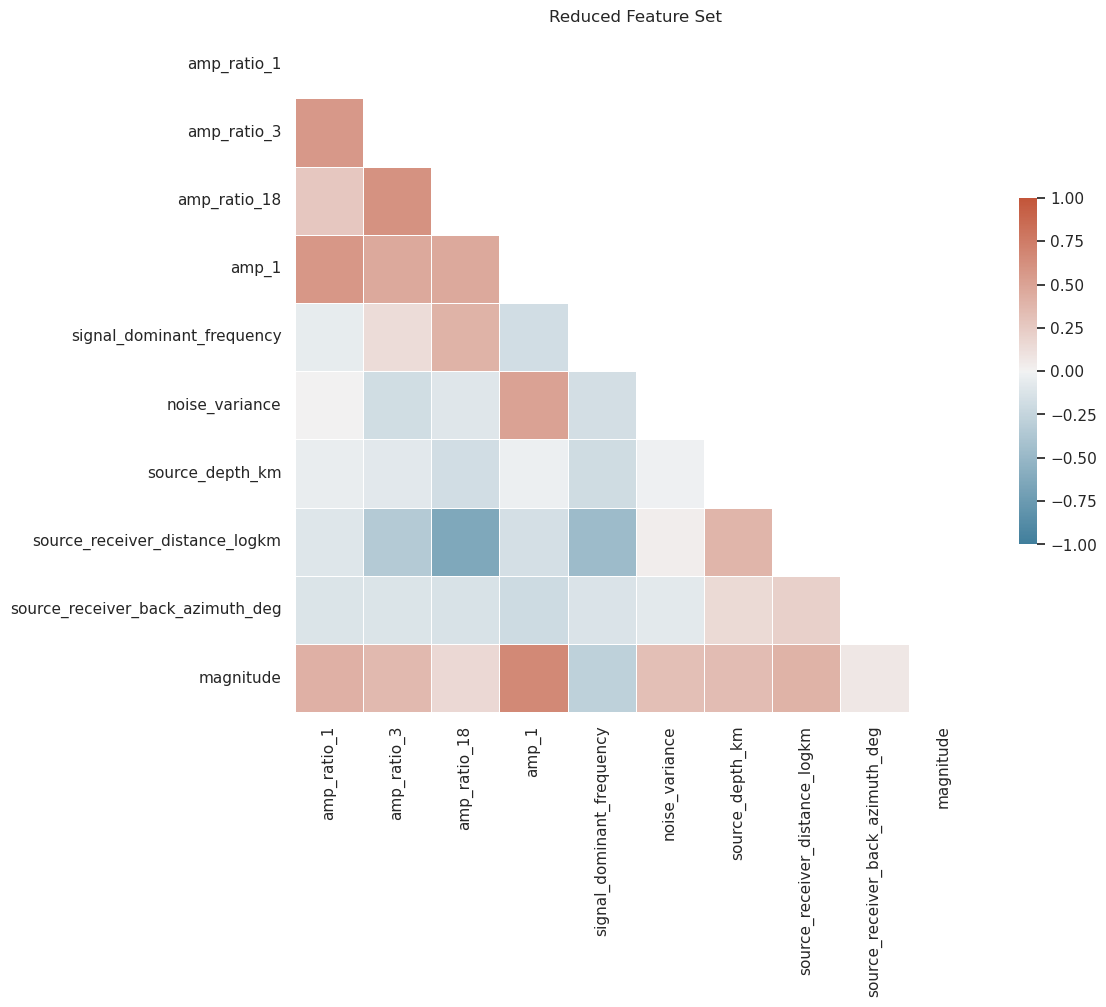

In [10]:
kept_features = np.isin(np.arange(0, feature_corr.shape[0]), dropped_feature_inds, invert=True)
kept_feature_names = feature_names[kept_features]
plot_pairwise_correlations(X[:, kept_features], y, kept_feature_names, "Reduced Feature Set",
                           xticklabels=1)

In [19]:
corr_gs_results, _ = CrossValidation.do_gridsearchcv(hp_grid_search,
                                X[:, kept_features],
                                y,
                                None)

In [20]:
CrossValidation.get_gridsearchcv_best_results(corr_gs_results)

(0.8745364314697618, 0.04293839702976155, {'m__C': 100, 'm__gamma': 0.01})

# Sequential Feature Selection

In [14]:
from sklearn.model_selection import cross_validate

In [11]:
cv_outer = RepeatedKFold(n_splits=cv_folds_outer, 
                            n_repeats=n_outer_repeats, 
                            random_state=cv_random_state)
inner_grid_search, cv_inner = CrossValidation.setup_cv(predictor_model, 
                                                                param_grid, 
                                                                model_scaler=model_scaler, 
                                                                scoring_method=scoring_method, 
                                                                n_jobs=n_jobs, 
                                                                cv_folds=cv_folds_inner, 
                                                                cv_random_state=cv_random_state, 
                                                                refit_model=True)

In [48]:
def seq_feature_importance(X,
                           y,
                           inner_grid_search,
                           cv_outer,
                           selected_feature_inds, 
                           all_feature_names,
                           starting_feature_inds=None,
                           stopping_tol=-1):
    feat_selection = np.copy(selected_feature_inds)
    r2_maxs = []
    r2_mins = []
    r2_means = []
    
    final_feature_set_size = len(selected_feature_inds)
    starting_feature_size = 0
    if starting_feature_inds is not None:
        starting_feature_size = len(starting_feature_inds)
        final_feature_set_size += starting_feature_size
    best_features = np.zeros(final_feature_set_size, dtype=int) 
    cnt = 0

    max_r2 = 0
    plot_start_ind = 1
    if starting_feature_inds is not None:
        best_features[0:starting_feature_size] = starting_feature_inds
        cnt += starting_feature_size
        X_train = np.copy(X[:, starting_feature_inds])
        cv_scores = cross_validate(inner_grid_search, 
                            X_train, 
                            y, 
                            scoring=scoring_method, 
                            cv=cv_outer, 
                            return_estimator=False)
        mean_cv = np.mean(cv_scores["test_score"])
        print(feature_names[starting_feature_inds], mean_cv)
        r2_means.append(mean_cv)
        r2_mins.append(mean_cv)
        r2_maxs.append(mean_cv)
        plot_start_ind = 0
        max_r2 = mean_cv

    for it in range(len(selected_feature_inds)):
        print("iteration", it)
        if it > 0:                
            print(best_features[0:cnt])
            print(all_feature_names[best_features[0:cnt]])

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in feat_selection:
            features = [feature_ind]
            if cnt == 0:
                X_train = np.copy(X[:, feature_ind:feature_ind+1])
            else:
                features = np.concatenate([best_features[0:cnt], features])
                X_train = np.copy(X[:, features])

            cv_scores = cross_validate(inner_grid_search, 
                            X_train, 
                            y, 
                            scoring=scoring_method, 
                            cv=cv_outer, 
                            return_estimator=False)

            mean_cv = np.mean(cv_scores["test_score"])
            print(all_feature_names[features[-1]], mean_cv)
            it_r2_vals.append(mean_cv)

        best_it_r2 = np.max(it_r2_vals)
        best_feat_ind = np.argmax(it_r2_vals)
        best_features[cnt] = feat_selection[best_feat_ind]
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))
        feat_selection = np.delete(feat_selection, best_feat_ind)

        print(best_it_r2, max_r2)
        if best_it_r2-max_r2 < stopping_tol:
            print('Stopping early')
            break

        if best_it_r2 > max_r2:
            max_r2 = best_it_r2
    
        cnt += 1
    
    n_features = np.arange(plot_start_ind, it+2)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features[:cnt]

In [12]:
seq_feature_importance(X[:100, :],
                        y[:100],
                        inner_grid_search,
                        cv_outer,
                        np.arange(X.shape[1])[kept_features], 
                        feature_names,
                        starting_feature_inds=None)

NameError: name 'seq_feature_importance' is not defined

['amp_ratio_1' 'amp_ratio_3' 'amp_ratio_18' 'amp_1'
 'signal_dominant_frequency' 'noise_variance' 'source_depth_km'
 'source_receiver_distance_logkm' 'source_receiver_back_azimuth_deg'] 0.8435369457562949
iteration 0
amp_ratio_2 0.8271620670211977
amp_ratio_4 0.8314736729232539
amp_ratio_5 0.8073976948355828
amp_ratio_6 0.830719438469224
amp_ratio_7 0.8281797489995905
amp_ratio_8 0.8280685035448873
amp_ratio_9 0.8324062683932898
amp_ratio_10 0.8344112671702149
amp_ratio_11 0.8359416488368488
amp_ratio_12 0.8392321689062736
amp_ratio_13 0.8349800850077138
amp_ratio_14 0.8387006683399552
amp_ratio_15 0.8375869012869996
amp_ratio_16 0.8382667980791517
amp_ratio_17 0.8382138722030034
amp_2 0.8641252318921679
amp_3 0.8653599548755171
amp_4 0.8614671634256043
amp_5 0.8547517155208368
amp_6 0.8478694196027765
amp_7 0.8382232089659422
amp_8 0.834518630295125
amp_9 0.8285270198360383
amp_10 0.842463652342712
amp_11 0.8457417106085238
amp_12 0.8472566218724247
amp_13 0.8502558064408895
amp_14 0.

array([ 0,  2, 17, 18, 36, 41, 42, 43, 44, 20, 23])

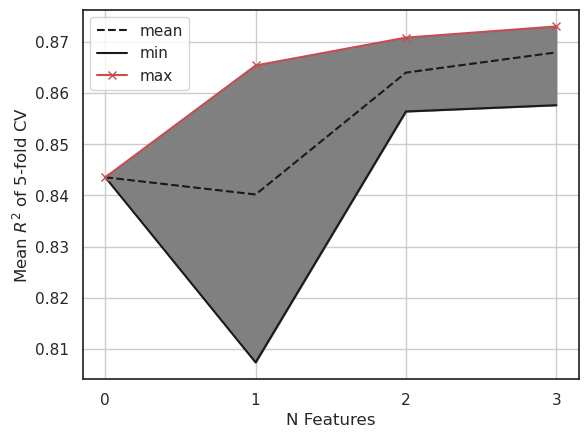

In [51]:
seq_feature_importance(X[:100, :],
                        y[:100],
                        inner_grid_search,
                        cv_outer,
                        np.arange(X.shape[1])[~kept_features], 
                        feature_names,
                        starting_feature_inds=np.arange(X.shape[1])[kept_features],
                        stopping_tol=0.005)

In [12]:
from src.feature_selection import SequentialFeatureSelection

In [13]:
SequentialFeatureSelection.do_forward_selection(X[:100, :],
                                                y[:100],
                                                X[100:110, :],
                                                y[100:110],
                                                inner_grid_search,
                                                np.arange(X.shape[1])[~kept_features][0:5], 
                                                score_func,
                                                early_stopping_tol=-0.05,
                                                required_feature_ids=np.arange(X.shape[1])[kept_features])

[0, 2, 17, 18, 36, 41, 42, 43, 44]


[ 0  2 17 18 36 41 42 43 44  1]
[ 0  2 17 18 36 41 42 43 44  3]
[ 0  2 17 18 36 41 42 43 44  4]
[ 0  2 17 18 36 41 42 43 44  5]
[ 0  2 17 18 36 41 42 43 44  6]
[ 0  2 17 18 36 41 42 43 44  5  1]
[ 0  2 17 18 36 41 42 43 44  5  3]
[ 0  2 17 18 36 41 42 43 44  5  4]
[ 0  2 17 18 36 41 42 43 44  5  6]
[ 0  2 17 18 36 41 42 43 44  5  6  1]
[ 0  2 17 18 36 41 42 43 44  5  6  3]
[ 0  2 17 18 36 41 42 43 44  5  6  4]
[ 0  2 17 18 36 41 42 43 44  5  6  1  3]
[ 0  2 17 18 36 41 42 43 44  5  6  1  4]
Stopping early


([0, 2, 17, 18, 36, 41, 42, 43, 44, 5, 6, 1, 3],
 [0.8483284073752726,
  0.894497094121057,
  0.8841981253604584,
  0.8595541152072521,
  0.8197885493917314],
 array([[0.83184043, 0.81060912, 0.85002962, 0.89449709, 0.88274229],
        [0.87592973, 0.85370199, 0.82583676,        nan, 0.88419813],
        [0.85955412, 0.84657167, 0.79551033,        nan,        nan],
        [       nan, 0.81978855, 0.76810868,        nan,        nan]]))